In [16]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

In [17]:
from util import fetch_data_if_not_exist

files = [f"steinmetz_part{i}.npz" for i in range(3)]
urls = [
    "https://osf.io/agvxh/download",
    "https://osf.io/uv3mw/download",
    "https://osf.io/ehmw2/download",
]

for file_name, url in zip(files, urls):
    fetch_data_if_not_exist(file_name, url)

In [18]:
alldata = np.array([])
for file in files:
    data = np.load(file, allow_pickle=True)["dat"] # np.load(file).files = ["dat"]
    alldata = np.hstack((alldata, data))

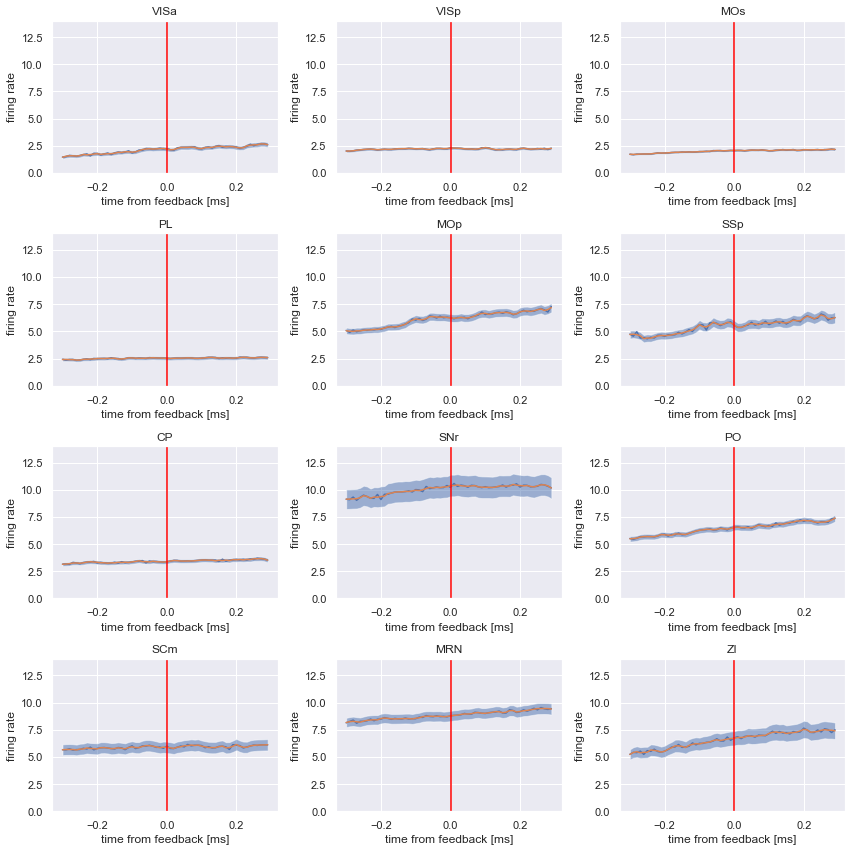

In [35]:
# 各領野について、フィードバック前後の平均発火頻度をニューロン単位のヒストグラムにする
from scipy.signal import savgol_filter

from_event = -0.3
to_event = 0.3


regions = ["VISa", "VISp", "MOs", "PL", "MOp", "SSp", "CP", "SNr", "PO", "SCm", "MRN", "ZI"]
# フィードバックされた時間を取り出す
# ひとまず試行は全試行を対象にする
# その時間の200ミリ秒前と200ミリ秒後について発火頻度の平均をニューロンごとに算出してヒストグラムに描く

time_bins = np.arange(0.0, 2.5, 0.01)

fig = plt.figure(figsize=(12, 12))

for i, reg in enumerate(regions):
    # 対象領野について全セッションのデータをまとめる

    # if i != 0:
    #     continue

    all_ave_neurons = np.array([])
    for j in range(39):
        dat = alldata[j]
        spikes = dat["spks"][dat["brain_area"] == reg]  # [neuron, trial, time_bin]
        dt = dat["bin_size"]
        from_event_idx = int(from_event / dt)
        to_event_idx = int(to_event / dt)

        n_reg_contained = spikes.shape[0]
        if n_reg_contained == 0:
            continue
        n_trials = len(dat["feedback_time"])

        fb_times: np.ndarray = dat["feedback_time"].reshape(-1)  # 報酬がもらえた時間
        if len(fb_times[fb_times < 2.5 - to_event]) == 0:
            continue
        fb_times[fb_times < from_event] = np.nan
        fb_times[fb_times >= 2.5 - to_event] = np.nan

        fb_types: np.ndarray = dat["feedback_type"]  # 報酬の種類
        fb_times[fb_types == -1] = np.nan

        neurons = np.array([])
        for k, fb_time in enumerate(fb_times):
            if np.isnan(fb_time):
                continue
            fb_time_idx = np.where(time_bins > fb_time)[0][0]
            slice = 1 / dt * spikes[:, k, fb_time_idx + from_event_idx : fb_time_idx + to_event_idx]
            if neurons.size == 0:
                neurons = np.array([slice])
            else:
                neurons = np.concatenate([neurons, slice[np.newaxis, :]], axis=0)  # type: ignore # [neuron, time_bin]

        ave_neurons = np.mean(neurons, axis=0)

        if all_ave_neurons.size == 0:
            all_ave_neurons = ave_neurons
        else:
            all_ave_neurons = np.concatenate([all_ave_neurons, ave_neurons], axis=0)  # type: ignore

    smoothed_ave_neurons = savgol_filter(all_ave_neurons, 5, 2, deriv=0)

    ax = plt.subplot(4, 3, i + 1)
    ax.set_title(reg)
    ax.set_xlabel("time from feedback [ms]")
    ax.set_ylabel("firing rate")
    ax.set_ylim(0, 14)

    x = np.arange(from_event, to_event, 0.01)

    mean = np.mean(all_ave_neurons, axis=0)
    smoothed_mean = np.mean(smoothed_ave_neurons, axis=0)
    smoothed_std = np.std(smoothed_ave_neurons, axis=0) / np.sqrt(smoothed_ave_neurons.shape[0])

    ax.plot(x, mean)
    ax.plot(x, smoothed_mean)

    ax.fill_between(x, smoothed_mean - smoothed_std, smoothed_mean + smoothed_std, alpha=0.5)

    ax.axvline(0, color='red')
